In [95]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

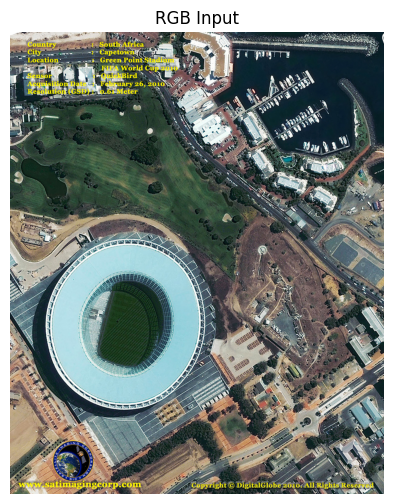

In [96]:
img = cv2.imread("rgb_input3.jpg")
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(6,6))
plt.imshow(img_rgb)
plt.axis("off")
plt.title("RGB Input")
plt.show()

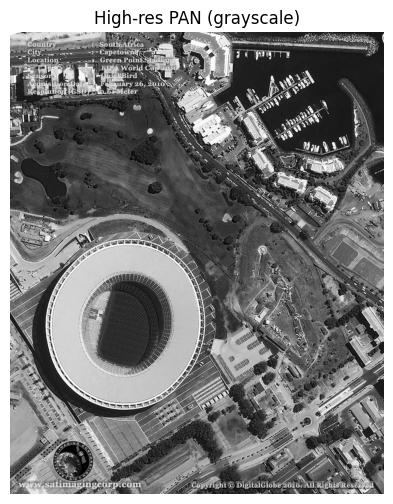

In [97]:
R = img_rgb[:, :, 0].astype(np.float32)
G = img_rgb[:, :, 1].astype(np.float32)
B = img_rgb[:, :, 2].astype(np.float32)

pan = 0.299 * R + 0.587 * G + 0.114 * B
pan = np.clip(pan, 0, 255).astype(np.uint8)

cv2.imwrite("pan_hr.png", pan)

plt.figure(figsize=(6,6))
plt.imshow(pan, cmap='gray')
plt.axis("off")
plt.title("High-res PAN (grayscale)")
plt.show()

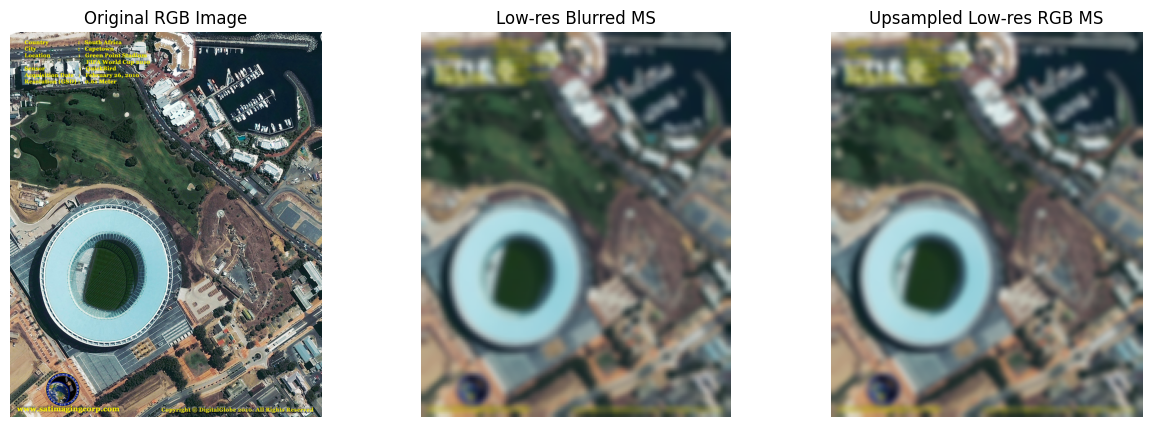

In [98]:
H, W = img_rgb.shape[:2]

scale = 0.25

rgb_low = cv2.resize(img_rgb, (int(W*scale), int(H*scale)), interpolation=cv2.INTER_AREA)

rgb_low_blur = cv2.GaussianBlur(rgb_low, (7,7), sigmaX=2)

rgb_lr_upsampled = cv2.resize(rgb_low_blur, (W, H), interpolation=cv2.INTER_CUBIC)

plt.figure(figsize=(15,5))
plt.subplot(1,3,1); plt.imshow(img_rgb);          plt.title("Original RGB Image"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(rgb_low_blur);     plt.title("Low-res Blurred MS"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(rgb_lr_upsampled); plt.title("Upsampled Low-res RGB MS"); plt.axis("off")
plt.show()


In [99]:
H_ms, W_ms = rgb_lr_upsampled.shape[:2]
pan_resized = cv2.resize(pan, (W_ms, H_ms), interpolation=cv2.INTER_CUBIC)

rgb = rgb_lr_upsampled.astype(np.float32) / 255.0
pan_f = pan_resized.astype(np.float32) / 255.0

R = rgb[:, :, 0]
G = rgb[:, :, 1]
B = rgb[:, :, 2]

I = (R + G + B) / 3.0

min_val = np.minimum(np.minimum(R, G), B)
S = 1 - (min_val / (I + 1e-6))

num = 0.5 * ((R - G) + (R - B))
den = np.sqrt((R - G)**2 + (R - B)*(G - B)) + 1e-6
theta = np.arccos(np.clip(num / den, -1, 1))

H = np.zeros_like(R)
H[B <= G] = theta[B <= G]
H[B >  G] = 2*np.pi - theta[B > G]

I_new = pan_f.copy()

R_new = np.zeros_like(R)
G_new = np.zeros_like(G)
B_new = np.zeros_like(B)

eps = 1e-6


idx1 = (H >= 0) & (H < 2*np.pi/3)
H1 = H[idx1]
S1 = S[idx1]
I1 = I_new[idx1]

B_new[idx1] = I1 * (1 - S1)
R_new[idx1] = I1 * (1 + (S1 * np.cos(H1)) / (np.cos(np.pi/3 - H1) + eps))
G_new[idx1] = 3*I1 - (R_new[idx1] + B_new[idx1])


idx2 = (H >= 2*np.pi/3) & (H < 4*np.pi/3)
H2 = H[idx2] - 2*np.pi/3
S2 = S[idx2]
I2 = I_new[idx2]

R_new[idx2] = I2 * (1 - S2)
G_new[idx2] = I2 * (1 + (S2 * np.cos(H2)) / (np.cos(np.pi/3 - H2) + eps))
B_new[idx2] = 3*I2 - (R_new[idx2] + G_new[idx2])


idx3 = (H >= 4*np.pi/3) & (H < 2*np.pi)
H3 = H[idx3] - 4*np.pi/3
S3 = S[idx3]
I3 = I_new[idx3]

G_new[idx3] = I3 * (1 - S3)
B_new[idx3] = I3 * (1 + (S3 * np.cos(H3)) / (np.cos(np.pi/3 - H3) + eps))
R_new[idx3] = 3*I3 - (G_new[idx3] + B_new[idx3])

ihs_rgb = np.stack([R_new, G_new, B_new], axis=2)
ihs_rgb = np.clip(ihs_rgb, 0, 1)
ihs_rgb_f = (ihs_rgb * 255).astype(np.uint8)

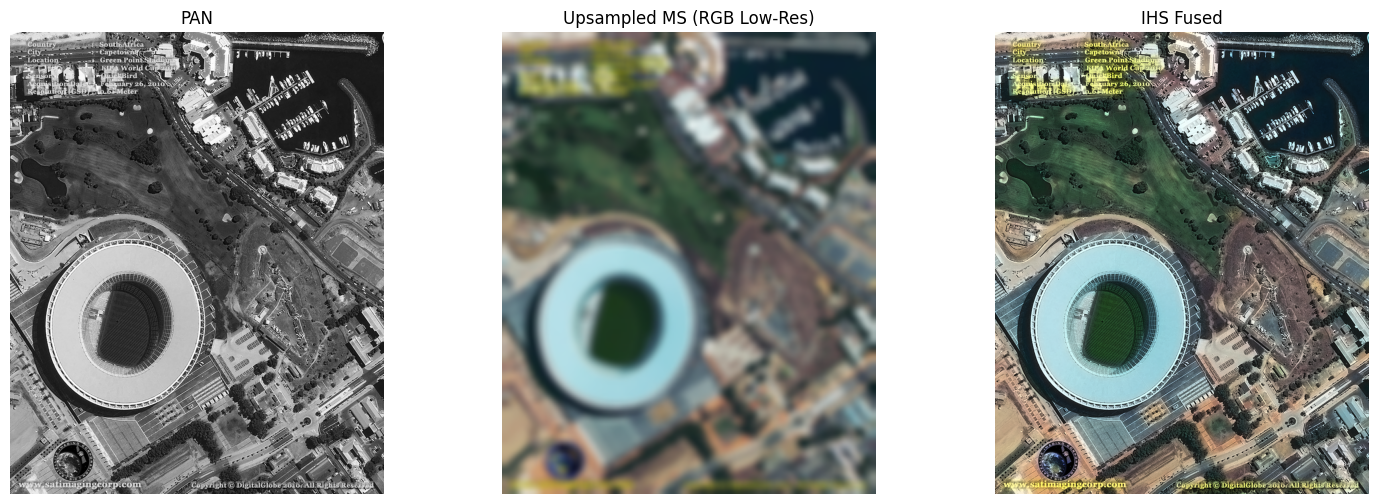

In [100]:
plt.figure(figsize=(18,6))
plt.subplot(1,3,2); plt.imshow(rgb_lr_upsampled); plt.title("Upsampled MS (RGB Low-Res)"); plt.axis("off")
plt.subplot(1,3,1); plt.imshow(pan_resized, cmap="gray"); plt.title("PAN"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(ihs_rgb); plt.title("IHS Fused"); plt.axis("off")
plt.show()

In [101]:
rgb_ms_f = rgb_lr_upsampled.astype(np.float32) / 255.0
pan_f    = pan.astype(np.float32) / 255.0

R = rgb_ms_f[:,:,0]
G = rgb_ms_f[:,:,1]
B = rgb_ms_f[:,:,2]

I = (R + G + B) / 3.0

In [102]:
def hist_match(source, template):
    oldshape = source.shape
    source   = source.ravel()
    template = template.ravel()

    s_values, bin_idx, s_counts = np.unique(source,   return_inverse=True, return_counts=True)
    t_values, t_counts          = np.unique(template, return_counts=True)

    s_quantiles = np.cumsum(s_counts).astype(np.float64)
    s_quantiles /= s_quantiles[-1]

    t_quantiles = np.cumsum(t_counts).astype(np.float64)
    t_quantiles /= t_quantiles[-1]

    interp_t_values = np.interp(s_quantiles, t_quantiles, t_values)
    return interp_t_values[bin_idx].reshape(oldshape)

P = hist_match(pan_f, I)

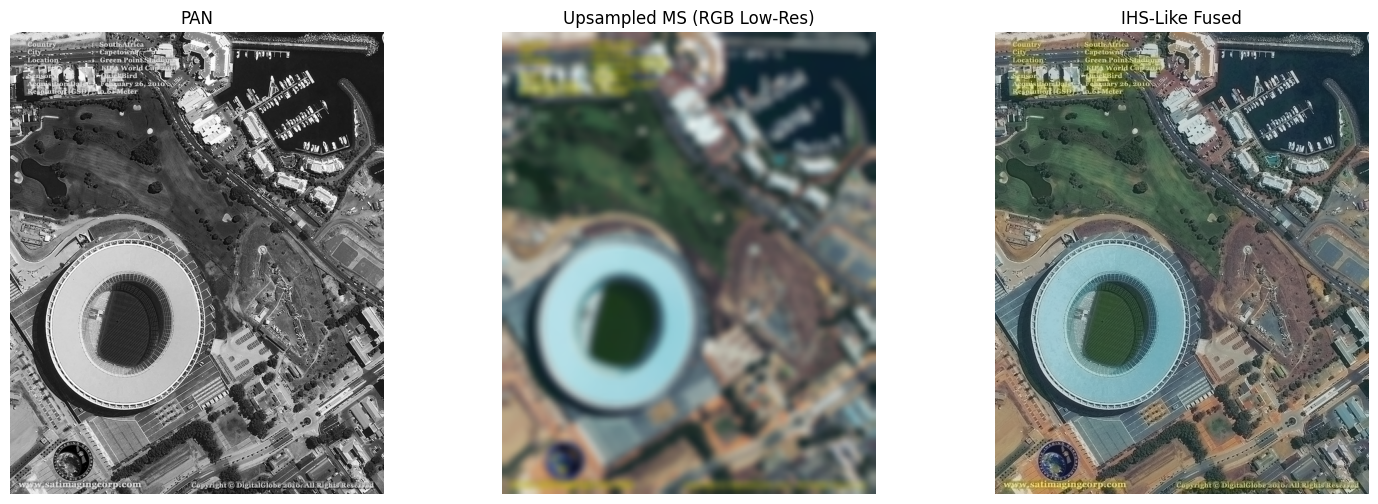

In [103]:
detail = P - I
k = 1.0

R_f = R + k*detail
G_f = G + k*detail
B_f = B + k*detail

R_f = np.clip(R_f, 0, 1)
G_f = np.clip(G_f, 0, 1)
B_f = np.clip(B_f, 0, 1)

ihs = np.stack([R_f, G_f, B_f], axis=2)
ihs_like = (ihs * 255).astype(np.uint8)

plt.figure(figsize=(18,6))
plt.subplot(1,3,2); plt.imshow(rgb_lr_upsampled); plt.title("Upsampled MS (RGB Low-Res)"); plt.axis("off")
plt.subplot(1,3,1); plt.imshow(pan, cmap="gray"); plt.title("PAN"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(ihs_like);   plt.title("IHS-Like Fused"); plt.axis("off")
plt.show()

In [104]:
import numpy as np
import math
import pandas as pd

In [105]:
def mse(img1, img2):
    return np.mean((img1 - img2) ** 2)

def psnr(img1, img2):
    m = mse(img1, img2)
    if m == 0:
        return float("inf")
    return 20 * np.log10(1.0 / np.sqrt(m))

def sam(img1, img2):
    p = img1.reshape(-1, 3)
    q = img2.reshape(-1, 3)
    num = np.sum(p * q, axis=1)
    den = np.linalg.norm(p, axis=1) * np.linalg.norm(q, axis=1) + 1e-12
    ang = np.arccos(np.clip(num / den, -1, 1))
    return np.mean(ang) * 180 / np.pi

def scc(img1, img2):
    p = np.mean(img1, axis=2).ravel()
    q = np.mean(img2, axis=2).ravel()
    return np.corrcoef(p, q)[0, 1]

In [106]:
hr_f        = img_rgb.astype(np.float32) / 255.0
ms_f        = rgb_lr_upsampled.astype(np.float32) / 255.0
ihs_f = ihs_rgb_f.astype(np.float32) / 255.0
ihs_like_f  = ihs_like.astype(np.float32) / 255.0

In [107]:
rows = [
    {
        "Image": "Upsampled MS",
        "MSE":      mse(hr_f, ms_f),
        "PSNR(dB)": psnr(hr_f, ms_f),
        "SAM(deg)": sam(hr_f, ms_f),
        "SCC":      scc(hr_f, ms_f)
    },
    {
        "Image": "IHS Fused",
        "MSE":      mse(hr_f, ihs_f),
        "PSNR(dB)": psnr(hr_f, ihs_f),
        "SAM(deg)": sam(hr_f, ihs_f),
        "SCC":      scc(hr_f, ihs_f)
    },
    {
        "Image": "IHS-Like Fused (Detail Injection)",
        "MSE":      mse(hr_f, ihs_like_f),
        "PSNR(dB)": psnr(hr_f, ihs_like_f),
        "SAM(deg)": sam(hr_f, ihs_like_f),
        "SCC":      scc(hr_f, ihs_like_f)
    }

]

df_metrics = pd.DataFrame(rows)
print(df_metrics)

                               Image       MSE   PSNR(dB)  SAM(deg)       SCC
0                       Upsampled MS  0.024644  16.082836  4.818986  0.799564
1                          IHS Fused  0.002078  26.823709  4.876498  0.996133
2  IHS-Like Fused (Detail Injection)  0.007305  21.363504  5.042161  0.988963


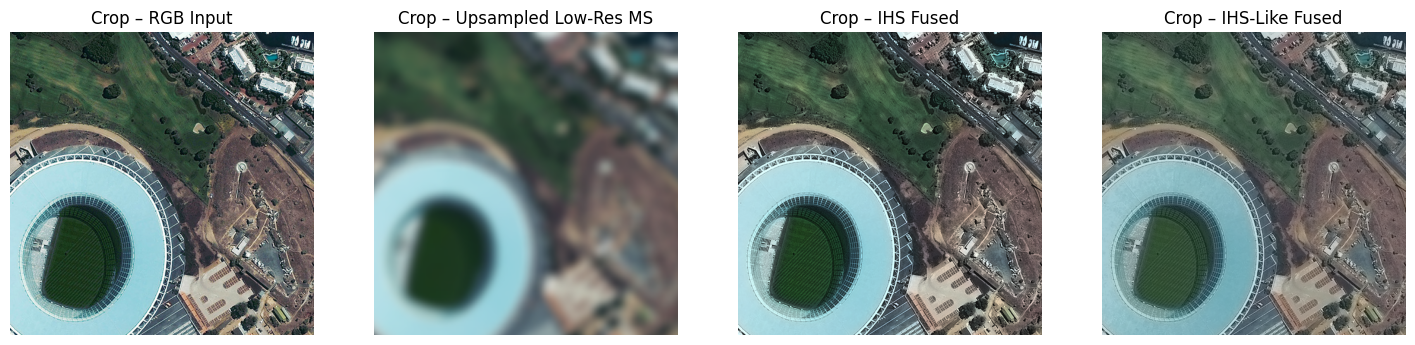

In [108]:
H, W = hr_f.shape[:2]
crop_size = 512
half = crop_size // 2

cy, cx = H // 2, W // 2

y1 = int(max(cy - half, 0))
y2 = int(min(cy + half, H))
x1 = int(max(cx - half, 0))
x2 = int(min(cx + half, W))

crop_hr        = hr_f       [y1:y2, x1:x2, :]
crop_ms        = ms_f       [y1:y2, x1:x2, :]
crop_ihs = ihs_f[y1:y2, x1:x2, :]
crop_ihs_like  = ihs_like_f [y1:y2, x1:x2, :]

plt.figure(figsize=(18,6))
plt.subplot(1,4,1); plt.imshow(crop_hr);        plt.title("Crop – RGB Input");   plt.axis("off")
plt.subplot(1,4,2); plt.imshow(crop_ms);        plt.title("Crop – Upsampled Low-Res MS");   plt.axis("off")
plt.subplot(1,4,3); plt.imshow(crop_ihs); plt.title("Crop – IHS Fused");  plt.axis("off")
plt.subplot(1,4,4); plt.imshow(crop_ihs_like);  plt.title("Crop – IHS-Like Fused");       plt.axis("off")
plt.show()

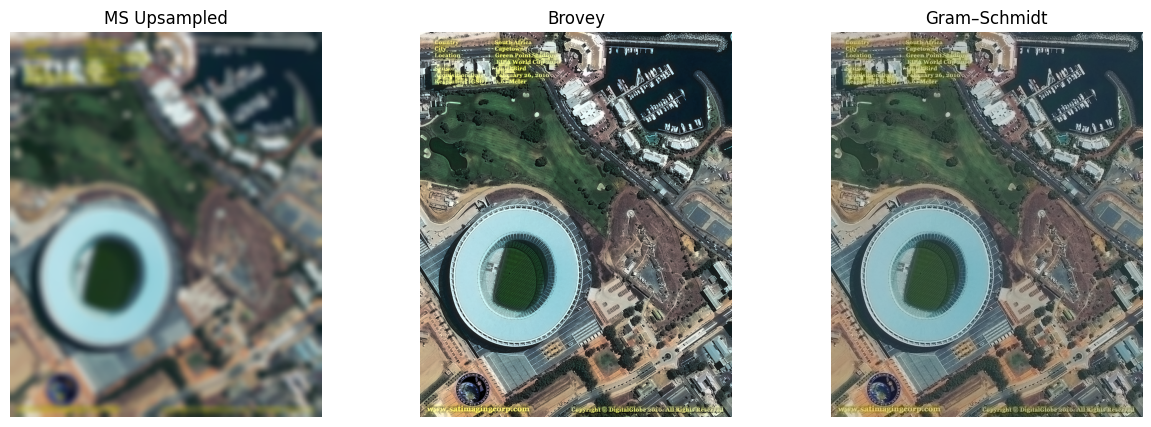

In [109]:
ms = rgb_lr_upsampled.astype(np.float32) / 255.0
pan_f = pan_resized.astype(np.float32) / 255.0
eps = 1e-6

#Brovey
I = np.mean(ms, axis=2)
gain = pan_f / (I + eps)
brovey_f = np.clip(ms * gain[..., None], 0, 1)
brovey_u8 = (brovey_f * 255).astype(np.uint8)

#Gram–Schmidt / Detail Injection baseline
I = np.mean(ms, axis=2)
pan_match2 = (pan_f - pan_f.mean()) / (pan_f.std() + eps)
pan_match2 = pan_match2 * (I.std() + eps) + I.mean()

detail = pan_match2 - I
gs_f = np.clip(ms + detail[..., None], 0, 1)
gs_u8 = (gs_f * 255).astype(np.uint8)


plt.figure(figsize=(15,5))
plt.subplot(1,3,1); plt.imshow(ms);       plt.title("MS Upsampled"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(brovey_f); plt.title("Brovey");       plt.axis("off")
plt.subplot(1,3,3); plt.imshow(gs_f);     plt.title("Gram–Schmidt"); plt.axis("off")
plt.show()

In [110]:
brovey_eval_f = brovey_u8.astype(np.float32) / 255.0
pca_eval_f    = pca_u8.astype(np.float32) / 255.0
gs_eval_f     = gs_u8.astype(np.float32) / 255.0

In [111]:
rows = [
    {
        "Image": "Upsampled MS",
        "MSE":      mse(hr_f, ms_f),
        "PSNR(dB)": psnr(hr_f, ms_f),
        "SAM(deg)": sam(hr_f, ms_f),
        "SCC":      scc(hr_f, ms_f)
    },
    {
        "Image": "IHS Fused",
        "MSE":      mse(hr_f, ihs_f),
        "PSNR(dB)": psnr(hr_f, ihs_f),
        "SAM(deg)": sam(hr_f, ihs_f),
        "SCC":      scc(hr_f, ihs_f)
    },
    {
        "Image": "IHS-Like Fused (Detail Injection)",
        "MSE":      mse(hr_f, ihs_like_f),
        "PSNR(dB)": psnr(hr_f, ihs_like_f),
        "SAM(deg)": sam(hr_f, ihs_like_f),
        "SCC":      scc(hr_f, ihs_like_f)
    },
        {
        "Image": "Brovey",
        "MSE":      mse(hr_f, brovey_eval_f),
        "PSNR(dB)": psnr(hr_f, brovey_eval_f),
        "SAM(deg)": sam(hr_f, brovey_eval_f),
        "SCC":      scc(hr_f, brovey_eval_f)
    },
    {
        "Image": "Gram–Schmidt",
        "MSE":      mse(hr_f, gs_eval_f),
        "PSNR(dB)": psnr(hr_f, gs_eval_f),
        "SAM(deg)": sam(hr_f, gs_eval_f),
        "SCC":      scc(hr_f, gs_eval_f)
    }


]

df_metrics = pd.DataFrame(rows)
print(df_metrics)

                               Image       MSE   PSNR(dB)  SAM(deg)       SCC
0                       Upsampled MS  0.024644  16.082836  4.818986  0.799564
1                          IHS Fused  0.002078  26.823709  4.876498  0.996133
2  IHS-Like Fused (Detail Injection)  0.007305  21.363504  5.042161  0.988963
3                             Brovey  0.002078  26.824223  4.876477  0.996132
4                       Gram–Schmidt  0.006708  21.734343  5.140752  0.996010


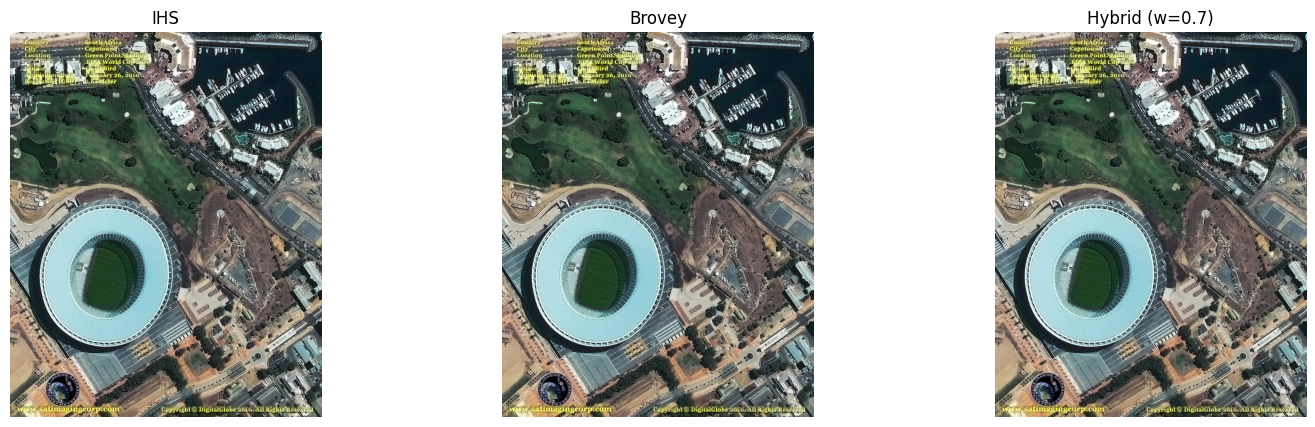

In [112]:
def to_float01(x):
    x = x.astype(np.float32)
    if x.max() > 1.0:
        x /= 255.0
    return np.clip(x, 0, 1)

ihs_f = to_float01(ihs_rgb_f)
bro_f = to_float01(brovey_u8)

w = 0.7
hybrid = np.clip(w * ihs_f + (1 - w) * bro_f, 0, 1)

plt.figure(figsize=(18,5))
plt.subplot(1,3,1); plt.imshow(ihs_f);    plt.title("IHS");    plt.axis("off")
plt.subplot(1,3,2); plt.imshow(bro_f);    plt.title("Brovey"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(hybrid);   plt.title(f"Hybrid (w={w})"); plt.axis("off")
plt.show()



In [113]:
img_rgb_up = cv2.resize(
    img_rgb,
    (hr_f.shape[1], hr_f.shape[0]),
    interpolation=cv2.INTER_LINEAR
)

img_rgb_up = img_rgb_up.astype(np.float32)
if img_rgb_up.max() > 1:
    img_rgb_up /= 255.0

In [114]:
rows = [
    {
        "Image": "RGB",
        "MSE":      mse(hr_f, img_rgb_up),
        "PSNR(dB)": psnr(hr_f, img_rgb_up),
        "SAM(deg)": sam(hr_f, img_rgb_up),
        "SCC":      scc(hr_f, img_rgb_up)
    },
    {
        "Image": "IHS Fused",
        "MSE":      mse(hr_f, ihs_f),
        "PSNR(dB)": psnr(hr_f, ihs_f),
        "SAM(deg)": sam(hr_f, ihs_f),
        "SCC":      scc(hr_f, ihs_f)
    },
    {
        "Image": "IHS-Like Fused (Detail Injection)",
        "MSE":      mse(hr_f, ihs_like_f),
        "PSNR(dB)": psnr(hr_f, ihs_like_f),
        "SAM(deg)": sam(hr_f, ihs_like_f),
        "SCC":      scc(hr_f, ihs_like_f)
    },
        {
        "Image": "Brovey",
        "MSE":      mse(hr_f, brovey_eval_f),
        "PSNR(dB)": psnr(hr_f, brovey_eval_f),
        "SAM(deg)": sam(hr_f, brovey_eval_f),
        "SCC":      scc(hr_f, brovey_eval_f)
    },
    {
        "Image": "Gram–Schmidt",
        "MSE":      mse(hr_f, gs_eval_f),
        "PSNR(dB)": psnr(hr_f, gs_eval_f),
        "SAM(deg)": sam(hr_f, gs_eval_f),
        "SCC":      scc(hr_f, gs_eval_f)
    },
        {
        "Image": "Hybrid",
        "MSE":      mse(hr_f, hybrid),
        "PSNR(dB)": psnr(hr_f, hybrid),
        "SAM(deg)": sam(hr_f, hybrid),
        "SCC":      scc(hr_f, hybrid)
    }


]

df_metrics = pd.DataFrame(rows)
print(df_metrics)

                               Image       MSE   PSNR(dB)  SAM(deg)       SCC
0                                RGB  0.000000        inf  0.062025  1.000000
1                          IHS Fused  0.002078  26.823709  4.876498  0.996133
2  IHS-Like Fused (Detail Injection)  0.007305  21.363504  5.042161  0.988963
3                             Brovey  0.002078  26.824223  4.876477  0.996132
4                       Gram–Schmidt  0.006708  21.734343  5.140752  0.996010
5                             Hybrid  0.002078  26.823957  4.876213  0.996133
